In [21]:
import gc  # Importing the garbage collection module for memory management.
import torch  # Importing PyTorch for deep learning capabilities.
import copy  # Importing the copy module for creating copies of objects.
from datasets import Dataset  # Importing Dataset class from the datasets module.
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments  # Importing specific classes and functions from the transformers module, which is used for natural language processing tasks.

In [22]:
import nltk  # Importing NLTK for natural language processing capabilities.
import numpy as np  # Importing NumPy for numerical computing.
import pandas as pd  # Importing Pandas for data manipulation and analysis.
import polars as pl  # Importing Polars for data manipulation and analysis.
import re  # Importing the re module for regular expressions.
import random  # Importing the random module for generating random numbers.
import matplotlib.pyplot as plt  # Importing Matplotlib for data visualization.
import warnings  # Importing the warnings module to manage warning messages.
warnings.filterwarnings('ignore')  # Ignoring warning messages during runtime.

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold  # Importing various functions and classes from scikit-learn for model training and evaluation.
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier  # Importing ensemble classifiers from scikit-learn.
from sklearn.linear_model import LogisticRegression, Perceptron  # Importing linear models from scikit-learn.
from sklearn.svm import LinearSVC  # Importing support vector machines from scikit-learn.
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB  # Importing Naive Bayes classifiers from scikit-learn.
from sklearn.neural_network import MLPClassifier  # Importing multi-layer perceptron classifier from scikit-learn.
from sklearn import tree  # Importing decision tree classifier from scikit-learn.
from sklearn.neighbors import KNeighborsClassifier  # Importing k-nearest neighbors classifier from scikit-learn.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Importing text vectorizers from scikit-learn.
from sklearn.pipeline import Pipeline  # Importing Pipeline class from scikit-learn for chaining preprocessing and modeling steps.
from imblearn.ensemble import BalancedBaggingClassifier  # Importing BalancedBaggingClassifier for handling imbalanced datasets.
from sklearn.feature_selection import SelectFromModel  # Importing SelectFromModel for feature selection.
from sklearn.datasets import make_classification  # Importing make_classification function for generating synthetic datasets.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, cohen_kappa_score  # Importing various evaluation metrics from scikit-learn.

In [24]:
from lightgbm import log_evaluation, early_stopping  # Importing specific functions from LightGBM for model training.
import lightgbm as lgb  # Importing LightGBM for gradient boosting.

nltk.download('wordnet')  # Downloading the WordNet corpus from NLTK.

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [25]:
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"  # Path to the test data CSV file.

# Load the CSV file into a DataFrame
test_data = pd.read_csv(TEST_DATA_PATH)

# Display the first few rows of the DataFrame
print(test_data.head())

MAX_LENGTH = 1024  # Maximum length allowed for input text sequences.
MODEL_PATH = "/kaggle/input/es-deberta-large-fold0"  # Path to the pre-trained model.

EVAL_BATCH_SIZE = 1  # Batch size for evaluation.
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/es-deberta-large-fold0")  # Initializing tokenizer from pre-trained model.

def tokenize(sample):  # Defining a function to tokenize each sample.
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)  # Tokenizing 'full_text' field of each sample.

df_test = pd.read_csv(TEST_DATA_PATH)  # Reading test data from the CSV file into a Pandas DataFrame.
ds = Dataset.from_pandas(df_test)  # Creating a Dataset object from the Pandas DataFrame.
ds = ds.map(tokenize).remove_columns(['essay_id', 'full_text'])  # Tokenizing each sample and removing 'essay_id' and 'full_text' columns.


  essay_id                                          full_text
0  000d118  Many people have car where they live. The thin...
1  000fe60  I am a scientist at NASA that is discussing th...
2  001ab80  People always wish they had the same technolog...


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [26]:
class DataCollator:  # Defining a custom data collator class.
    def __call__(self, features):  # Implementing the __call__ method to process features.
        model_inputs = [{  # Creating a list comprehension to extract 'input_ids' and 'attention_mask' from each feature.
            'input_ids': feature['input_ids'],  # Extracting 'input_ids' from the feature.
            'attention_mask': feature['attention_mask']  # Extracting 'attention_mask' from the feature.
        } for feature in features]  # Iterating over all features.

        batch = tokenizer.pad(  # Padding the model inputs using the tokenizer.
            model_inputs,  # Model inputs containing 'input_ids' and 'attention_mask'.
            padding=True,  # Enabling padding.
            max_length=MAX_LENGTH,  # Specifying the maximum length for padding.
            return_tensors='pt',  # Returning PyTorch tensors.
            pad_to_multiple_of=16  # Padding to a multiple of 16.
        )
        return batch  # Returning the padded batch of inputs.

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)  # Loading the pre-trained model for sequence classification.
collator = DataCollator()  # Creating an instance of the custom data collator.
args = TrainingArguments(".", per_device_eval_batch_size=EVAL_BATCH_SIZE, report_to="none")  # Setting up training arguments.
trainer = Trainer(model=model, args=args, data_collator=collator, tokenizer=tokenizer)  # Creating a Trainer instance for model training.
predicts = trainer.predict(ds).predictions  # Making predictions on the dataset using the Trainer instance.

del model, trainer  # Deleting the model and trainer objects to free up memory.
torch.cuda.empty_cache()  # Emptying the CUDA cache to release GPU memory.
gc.collect()  # Performing garbage collection to free up additional memory.


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


251

In [28]:
pred1 = predicts.argmax(-1) + 1

Here's what it does:
- `predicts` contains the output probabilities of the model for each class. Each row corresponds to a sample, and each column corresponds to the probability of that sample belonging to a particular class.
- `.argmax(-1)` finds the index of the maximum value along the last dimension (i.e., along the classes dimension). This effectively gives the predicted class label for each sample.
- `+ 1` is added to convert the class index (which typically starts from 0) to a class label starting from 1. This adjustment might be necessary based on the labeling convention used in the dataset.


In [29]:
pred1

array([3, 3, 4])

In [30]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]

In [31]:
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

In [32]:
train = pl.read_csv(PATH + "train.csv").with_columns(columns)

In [33]:
test = pl.read_csv(PATH + "test.csv").with_columns(columns)


In [34]:
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


This code performs the following steps:

Defines a transformation to split the "full_text" column into paragraphs using Polars.
Specifies the path to the directory containing the CSV files.
Reads the "train.csv" file, applies the defined transformation, and stores the result in the train DataFrame.
Reads the "test.csv" file, applies the same transformation, and stores the result in the test DataFrame.
Displays the first row of the train DataFrame to inspect the changes made.

In [35]:
import re

cList = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", 
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", 
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", 
    "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", 
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
    "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", 
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", 
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", 
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
    "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", 
    "that'd've": "that would have", "that's": "that is", "there'd": "there had", "there'd've": "there would have", 
    "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
    "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
    "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", 
    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", 
    "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", 
    "you'll've": "you you will have", "you're": "you are", "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x


1. `expandContractions`: This function expands contractions in the text using a predefined dictionary (`cList`), which maps contractions to their expanded forms. For example, "can't" becomes "cannot", "I'll" becomes "I will", etc.

2. `removeHTML`: This function removes HTML tags from the text using regular expressions.

3. `dataPreprocessing`: This function applies a series of text preprocessing steps to the input text:
   - Converts the text to lowercase.
   - Removes HTML tags using the `removeHTML` function.
   - Removes Twitter handles (words starting with '@').
   - Removes apostrophes followed by digits.
   - Removes digits.
   - Removes URLs starting with 'http'.
   - Replaces multiple whitespace characters with a single space.
   - Replaces consecutive periods ('.') with a single period.
   - Replaces consecutive commas (',') with a single comma.
   - Strips leading and trailing whitespace.


In [36]:

# Define a function to preprocess paragraph data
def Paragraph_Preprocess(tmp):
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

# Define a function to extract paragraph-based features
def Paragraph_Eng(train_tmp):
    # Define paragraph features
    paragraph_fea = ['paragraph_len', 'paragraph_sentence_cnt', 'paragraph_word_cnt']
    # Define aggregation functions for paragraph features
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
    ]
    # Group by 'essay_id' and aggregate paragraph features
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    # Convert the result to a pandas DataFrame
    df = df.to_pandas()
    return df

# Preprocess paragraph data
tmp = Paragraph_Preprocess(train)
# Extract paragraph-based features
train_feats = Paragraph_Eng(tmp)
# Add essay score to the feature DataFrame
train_feats['score'] = train['score']
# Get feature names excluding 'essay_id' and 'score'
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
# Print the number of features
print('Number of Features: ',len(feature_names))
# Display the first three rows of the feature DataFrame
train_feats.head(3)

Number of Features:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4



1. `Paragraph_Preprocess`: This function preprocesses the paragraph data in the input DataFrame `tmp`. It performs the following steps:
   - Explodes the DataFrame on the 'paragraph' column, creating multiple rows for each essay, each containing a single paragraph.
   - Applies the `dataPreprocessing` function to each paragraph to clean and preprocess the text.
   - Computes additional features for each paragraph, such as the length of the paragraph, the number of sentences, and the number of words.
   - Returns the preprocessed DataFrame.

2. `Paragraph_Eng`: This function extracts paragraph-based features from the preprocessed DataFrame `train_tmp`. It calculates various statistics and counts for each essay's paragraphs, such as paragraph length distribution, maximum, minimum, and average paragraph length, etc. The extracted features are then returned as a pandas DataFrame.

After defining these functions, the code applies them to the training data (`train`) to generate paragraph-based features (`train_feats`). It also includes the essay's score in the final DataFrame.

Finally, it prints the number of extracted features and displays the first three rows of the DataFrame `train_feats`.


In [37]:
def Sentence_Preprocess(tmp):
    # Split the 'full_text' into sentences and preprocess each sentence
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    # Explode the DataFrame on the 'sentence' column to create multiple rows for each essay
    tmp = tmp.explode('sentence')
    # Compute the length of each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # Filter out sentences with length less than 15 characters
    tmp = tmp.filter(pl.col('sentence_len') >= 15)
    # Compute the word count for each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']

def Sentence_Eng(train_tmp):
    # Define aggregation functions for sentence features
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
    ]
    # Group by 'essay_id' and aggregate sentence features
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    # Convert the result to a pandas DataFrame
    df = df.to_pandas()
    return df

# Preprocess sentences and extract sentence-based features
tmp = Sentence_Preprocess(train)
# Merge sentence-based features with existing features
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Get feature names excluding 'essay_id' and 'score'
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
# Print the number of features
print('Number of Features: ',len(feature_names))
# Display the first three rows of the feature DataFrame
train_feats.head(3)

Number of Features:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


In [38]:
def Word_Preprocess(tmp):
    # Apply data preprocessing function to each word in 'full_text' column
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    # Explode the DataFrame on the 'word' column to create multiple rows for each word
    tmp = tmp.explode('word')
    # Compute the length of each word and filter out zero-length words
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len') != 0)
    return tmp

def Word_Eng(train_tmp):
    # Define aggregation functions for word features
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
    ]
    # Group by 'essay_id' and aggregate word features
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    # Convert the result to a pandas DataFrame
    df = df.to_pandas()
    return df

# Preprocess word data
tmp = Word_Preprocess(train)
# Extract word-based features and merge them with existing features
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
# Get feature names excluding 'essay_id' and 'score'
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
# Print the number of features
print('Number of Features: ',len(feature_names))
# Display the first three rows of the feature DataFrame
train_feats.head(3)


Number of Features:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define TF-IDF vectorizer with specified parameters
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,  # No tokenization as the text is already tokenized
    preprocessor=lambda x: x,  # No preprocessing as the text is already preprocessed
    token_pattern=None,  # Disable token pattern
    strip_accents='unicode',  # Strip accents using Unicode
    analyzer='word',  # Use word-level analyzer
    ngram_range=(1, 4),  # Use unigrams, bigrams, trigrams, and four-grams
    min_df=0.05,  # Ignore terms that have a document frequency strictly lower than 5%
    max_df=0.95,  # Ignore terms that have a document frequency strictly higher than 95%
    sublinear_tf=True,  # Apply sublinear TF scaling
)

# Fit and transform the vectorizer on the training data
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
# Convert the sparse matrix to a dense matrix
dense_matrix = train_tfid.toarray()
# Create a DataFrame from the dense matrix
df = pd.DataFrame(dense_matrix)
# Rename columns with TF-IDF feature names
tfid_columns = [f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
# Add 'essay_id' to the DataFrame for merging
df['essay_id'] = train_feats['essay_id']
# Merge TF-IDF features with existing features on 'essay_id'
train_feats = train_feats.merge(df, on='essay_id', how='left')
# Get feature names excluding 'essay_id' and 'score'
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
# Print the number of features
print('Number of Features: ', len(feature_names))
# Display the first three rows of the feature DataFrame
train_feats.head(3)

Number of Features:  8741


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_8662,tfid_8663,tfid_8664,tfid_8665,tfid_8666,tfid_8667,tfid_8668,tfid_8669,tfid_8670,tfid_8671
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.023801,0.048692,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [40]:
import numpy as np
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_true, y_pred):
    # Add a constant 'a' to both true and predicted labels
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()  # Clip predictions to [1, 6] and round
    # Calculate Quadratic Weighted Kappa
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

def qwk_obj(y_true, y_pred):
    # Add constants 'a' and 'b' to true and predicted labels
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)  # Clip predictions to [1, 6]
    # Calculate the objective function
    f = 1/2 * np.sum((preds - labels) ** 2)
    g = 1/2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g**2) * len(labels)
    hess = np.ones(len(labels))  # Hessian is a vector of ones
    return grad, hess

# Predefined constants
a = 2.948
b = 1.092



1. **quadratic_weighted_kappa**: This function calculates the Quadratic Weighted Kappa metric given the true labels (`y_true`) and predicted labels (`y_pred`). It adjusts the labels and predictions by adding a constant `a` to them, and then clips the predictions to ensure they are within the range [1, 6]. After that, it computes the QWK score using the `cohen_kappa_score` function from scikit-learn with quadratic weights. It returns a tuple containing the name of the metric ('QWK'), the computed QWK score, and a boolean indicating whether higher scores are better.

2. **qwk_obj**: This function defines the objective function for optimizing the QWK metric during training. It takes the true labels (`y_true`) and predicted labels (`y_pred`) as input. Similar to `quadratic_weighted_kappa`, it adjusts the labels and predictions by adding a constant `a` to them and clips the predictions to the range [1, 6]. Then, it calculates the gradient (`grad`) and Hessian (`hess`) of the objective function with respect to the predicted labels. These gradients and Hessians are used by the optimization algorithm to update the model parameters. The constants `a` and `b` are predefined values used in the computation.

These functions are typically used in the context of training machine learning models, especially in scenarios where optimizing directly for the QWK metric is desired, such as in gradient boosting algorithms like LightGBM or XGBoost.


In [41]:
import numpy as np

# Extracting features and converting to NumPy array of type np.float32
X = train_feats[feature_names].astype(np.float32).values

# Extracting target variable 'score' and converting to integer
y_split = train_feats['score'].astype(int).values

# Extracting target variable 'score', converting to float32, and subtracting constant 'a'
y = train_feats['score'].astype(np.float32).values - a


Fold_1 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.80847	valid's QWK: 0.760434
[50]	train's QWK: 0.838588	valid's QWK: 0.783443
[75]	train's QWK: 0.860235	valid's QWK: 0.788851
[100]	train's QWK: 0.875986	valid's QWK: 0.788772
[125]	train's QWK: 0.890717	valid's QWK: 0.78628
[150]	train's QWK: 0.903807	valid's QWK: 0.78696
[175]	train's QWK: 0.915281	valid's QWK: 0.785383
Early stopping, best iteration is:
[109]	train's QWK: 0.881535	valid's QWK: 0.793215
Evaluated only: QWK


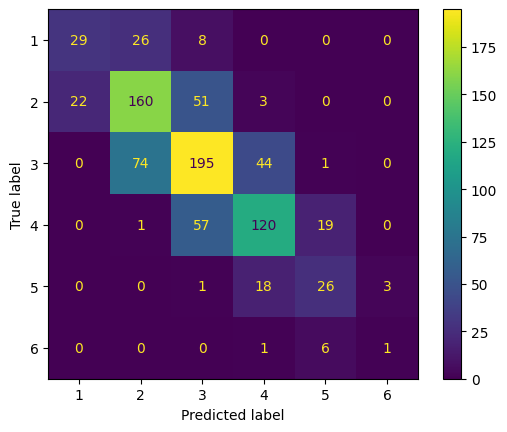

F1 score across fold: 0.6112784683193543
Cohen kappa score across fold: 0.793215341828085

Fold_2 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.807395	valid's QWK: 0.778372
[50]	train's QWK: 0.838557	valid's QWK: 0.806938
[75]	train's QWK: 0.85783	valid's QWK: 0.8087
[100]	train's QWK: 0.874629	valid's QWK: 0.813165
[125]	train's QWK: 0.889895	valid's QWK: 0.817611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.901916	valid's QWK: 0.818291
[175]	train's QWK: 0.914472	valid's QWK: 0.814562
[200]	train's QWK: 0.925888	valid's QWK: 0.811963
Early stopping, best iteration is:
[137]	train's QWK: 0.896127	valid's QWK: 0.81974
Evaluated only: QWK


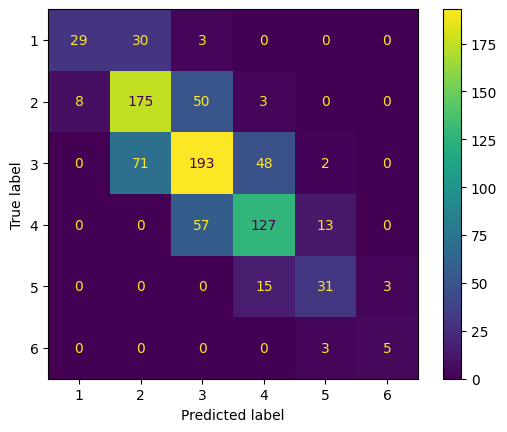

F1 score across fold: 0.6447976492072504
Cohen kappa score across fold: 0.8197396954914109

Fold_3 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.804642	valid's QWK: 0.769596
[50]	train's QWK: 0.840113	valid's QWK: 0.790093
[75]	train's QWK: 0.859965	valid's QWK: 0.793358
[100]	train's QWK: 0.876068	valid's QWK: 0.791615
[125]	train's QWK: 0.889742	valid's QWK: 0.79109
Early stopping, best iteration is:
[69]	train's QWK: 0.855046	valid's QWK: 0.796634
Evaluated only: QWK


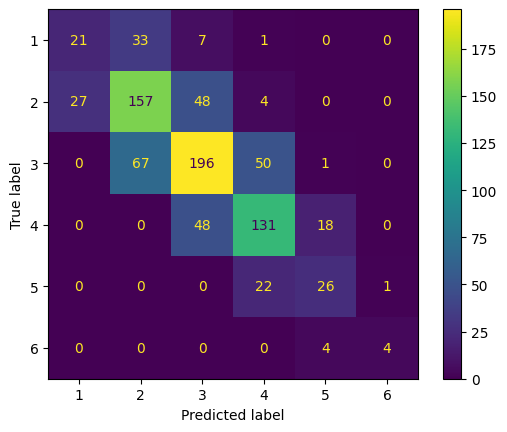

F1 score across fold: 0.6156423066493182
Cohen kappa score across fold: 0.7966344329372689

Fold_4 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806522	valid's QWK: 0.768318
[50]	train's QWK: 0.839813	valid's QWK: 0.789124
[75]	train's QWK: 0.858775	valid's QWK: 0.798083
[100]	train's QWK: 0.875272	valid's QWK: 0.801386
[125]	train's QWK: 0.889768	valid's QWK: 0.805003
[150]	train's QWK: 0.902434	valid's QWK: 0.803813
[175]	train's QWK: 0.914181	valid's QWK: 0.799532
[200]	train's QWK: 0.925724	valid's QWK: 0.804146
Early stopping, best iteration is:
[136]	train's QWK: 0.895942	valid's QWK: 0.805988
Evaluated only: QWK


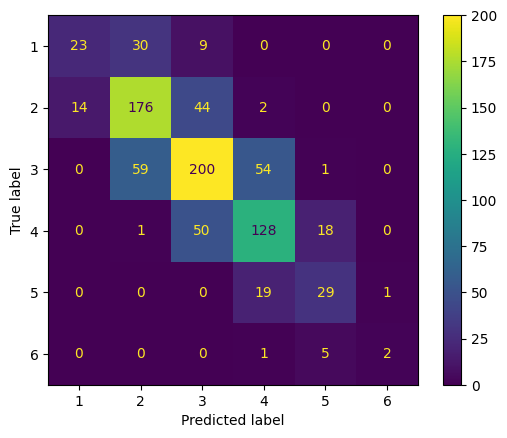

F1 score across fold: 0.6401769223530722
Cohen kappa score across fold: 0.8059879380953661

Fold_5 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.803942	valid's QWK: 0.766903
[50]	train's QWK: 0.836725	valid's QWK: 0.788523
[75]	train's QWK: 0.858107	valid's QWK: 0.793461
[100]	train's QWK: 0.873925	valid's QWK: 0.788525
[125]	train's QWK: 0.888198	valid's QWK: 0.788126
Early stopping, best iteration is:
[56]	train's QWK: 0.842504	valid's QWK: 0.79707
Evaluated only: QWK


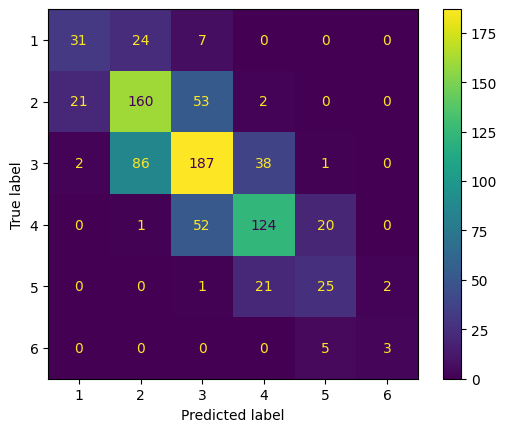

F1 score across fold: 0.6113672118263227
Cohen kappa score across fold: 0.7970697523907294

Fold_6 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.803004	valid's QWK: 0.798529
[50]	train's QWK: 0.836889	valid's QWK: 0.809941
[75]	train's QWK: 0.856769	valid's QWK: 0.810282
[100]	train's QWK: 0.873808	valid's QWK: 0.810967
Early stopping, best iteration is:
[38]	train's QWK: 0.824043	valid's QWK: 0.816273
Evaluated only: QWK


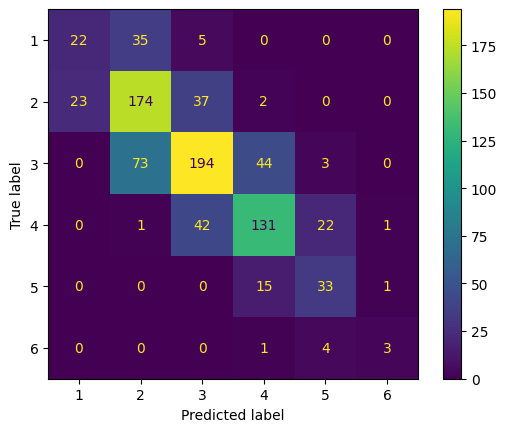

F1 score across fold: 0.640538604546891
Cohen kappa score across fold: 0.8162733051028284

Fold_7 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.803226	valid's QWK: 0.775288
[50]	train's QWK: 0.836813	valid's QWK: 0.782388
[75]	train's QWK: 0.858162	valid's QWK: 0.79386
[100]	train's QWK: 0.874547	valid's QWK: 0.799296
[125]	train's QWK: 0.889467	valid's QWK: 0.797394
[150]	train's QWK: 0.902097	valid's QWK: 0.794863
Early stopping, best iteration is:
[92]	train's QWK: 0.869479	valid's QWK: 0.803501
Evaluated only: QWK


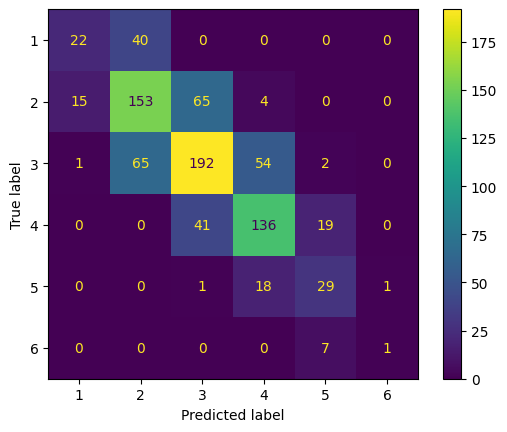

F1 score across fold: 0.6115072562089692
Cohen kappa score across fold: 0.8035008103727714

Fold_8 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.802684	valid's QWK: 0.76906
[50]	train's QWK: 0.837361	valid's QWK: 0.792301
[75]	train's QWK: 0.856384	valid's QWK: 0.798335
[100]	train's QWK: 0.87287	valid's QWK: 0.804345
[125]	train's QWK: 0.887603	valid's QWK: 0.810524
[150]	train's QWK: 0.900122	valid's QWK: 0.806326
[175]	train's QWK: 0.912855	valid's QWK: 0.81095
[200]	train's QWK: 0.923816	valid's QWK: 0.807368
Early stopping, best iteration is:
[127]	train's QWK: 0.889108	valid's QWK: 0.811789
Evaluated only: QWK


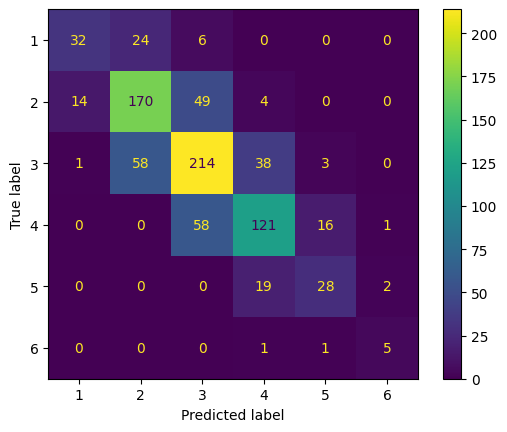

F1 score across fold: 0.6577509531023021
Cohen kappa score across fold: 0.8117894010336215

Fold_9 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.805123	valid's QWK: 0.770951
[50]	train's QWK: 0.837113	valid's QWK: 0.785941
[75]	train's QWK: 0.858755	valid's QWK: 0.801221
[100]	train's QWK: 0.874628	valid's QWK: 0.806367
[125]	train's QWK: 0.888605	valid's QWK: 0.806782
[150]	train's QWK: 0.901981	valid's QWK: 0.806008
[175]	train's QWK: 0.914683	valid's QWK: 0.805146
[200]	train's QWK: 0.925771	valid's QWK: 0.804988
Early stopping, best iteration is:
[131]	train's QWK: 0.891867	valid's QWK: 0.809621
Evaluated only: QWK


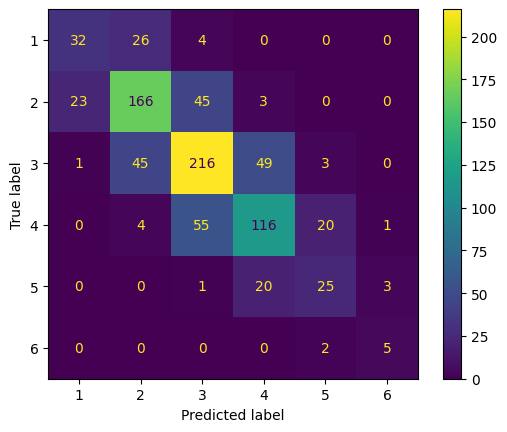

F1 score across fold: 0.6467006200660026
Cohen kappa score across fold: 0.8096214314064669

Fold_10 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.80567	valid's QWK: 0.762643
[50]	train's QWK: 0.83721	valid's QWK: 0.787561
[75]	train's QWK: 0.857843	valid's QWK: 0.796402
[100]	train's QWK: 0.87473	valid's QWK: 0.803469
[125]	train's QWK: 0.888989	valid's QWK: 0.803639
[150]	train's QWK: 0.902739	valid's QWK: 0.800484
Early stopping, best iteration is:
[94]	train's QWK: 0.871234	valid's QWK: 0.805434
Evaluated only: QWK


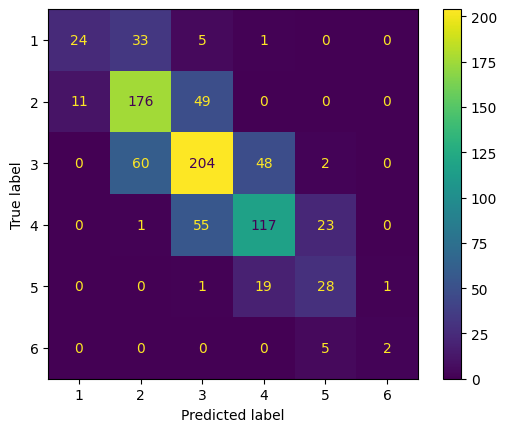

F1 score across fold: 0.6333570733752725
Cohen kappa score across fold: 0.8054344428439305

Fold_11 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.807295	valid's QWK: 0.747783
[50]	train's QWK: 0.837339	valid's QWK: 0.779205
[75]	train's QWK: 0.859126	valid's QWK: 0.787456
[100]	train's QWK: 0.874522	valid's QWK: 0.792843
[125]	train's QWK: 0.889156	valid's QWK: 0.793725
[150]	train's QWK: 0.902241	valid's QWK: 0.79004
Early stopping, best iteration is:
[94]	train's QWK: 0.871263	valid's QWK: 0.794441
Evaluated only: QWK


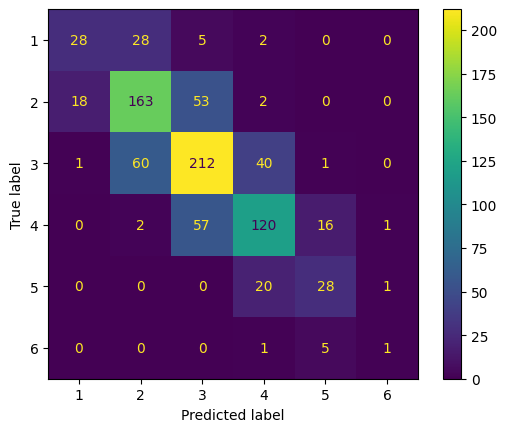

F1 score across fold: 0.6354777656313144
Cohen kappa score across fold: 0.7944410219055406

Fold_12 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.804765	valid's QWK: 0.774673
[50]	train's QWK: 0.837244	valid's QWK: 0.794741
[75]	train's QWK: 0.858333	valid's QWK: 0.797513
[100]	train's QWK: 0.87516	valid's QWK: 0.800578
[125]	train's QWK: 0.890098	valid's QWK: 0.797618
Early stopping, best iteration is:
[58]	train's QWK: 0.844791	valid's QWK: 0.8023
Evaluated only: QWK


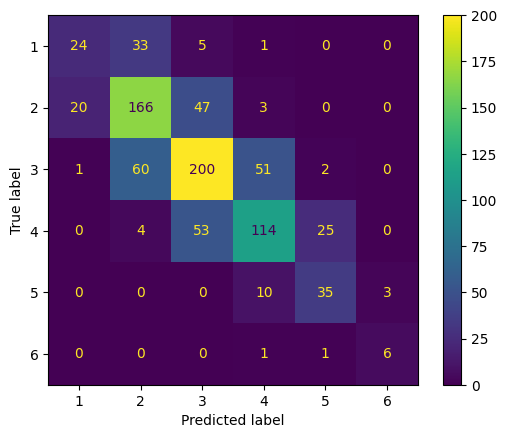

F1 score across fold: 0.6273923063459759
Cohen kappa score across fold: 0.8023001361602802

Fold_13 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806214	valid's QWK: 0.769311
[50]	train's QWK: 0.838286	valid's QWK: 0.804693
[75]	train's QWK: 0.857527	valid's QWK: 0.813073
[100]	train's QWK: 0.873726	valid's QWK: 0.818581
[125]	train's QWK: 0.886647	valid's QWK: 0.814696
[150]	train's QWK: 0.899868	valid's QWK: 0.815358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.912197	valid's QWK: 0.819155
[200]	train's QWK: 0.923662	valid's QWK: 0.813789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	train's QWK: 0.933999	valid's QWK: 0.815103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[174]	train's QWK: 0.911954	valid

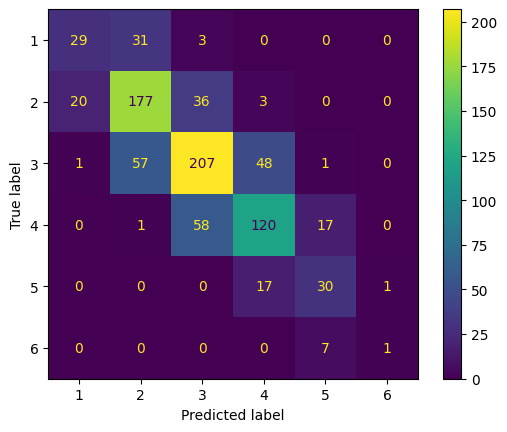

F1 score across fold: 0.6487506052652754
Cohen kappa score across fold: 0.8210979786820826

Fold_14 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.80866	valid's QWK: 0.761845
[50]	train's QWK: 0.83881	valid's QWK: 0.785578
[75]	train's QWK: 0.85931	valid's QWK: 0.781817
[100]	train's QWK: 0.87737	valid's QWK: 0.78222
Early stopping, best iteration is:
[49]	train's QWK: 0.837765	valid's QWK: 0.789053
Evaluated only: QWK


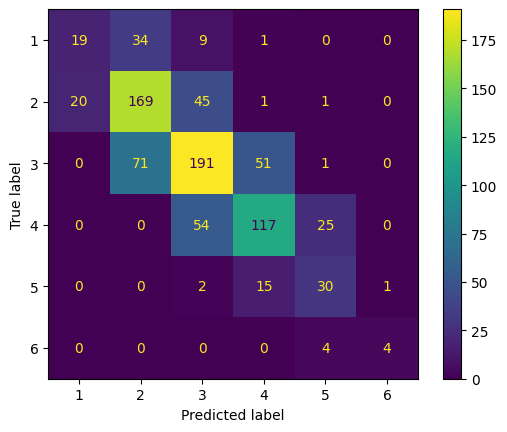

F1 score across fold: 0.608831072571259
Cohen kappa score across fold: 0.7890534135391003

Fold_15 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.8049	valid's QWK: 0.792351
[50]	train's QWK: 0.836315	valid's QWK: 0.80687
[75]	train's QWK: 0.857013	valid's QWK: 0.807908
[100]	train's QWK: 0.8748	valid's QWK: 0.816596
[125]	train's QWK: 0.88857	valid's QWK: 0.813685
[150]	train's QWK: 0.901099	valid's QWK: 0.80897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[96]	train's QWK: 0.872235	valid's QWK: 0.817273
Evaluated only: QWK


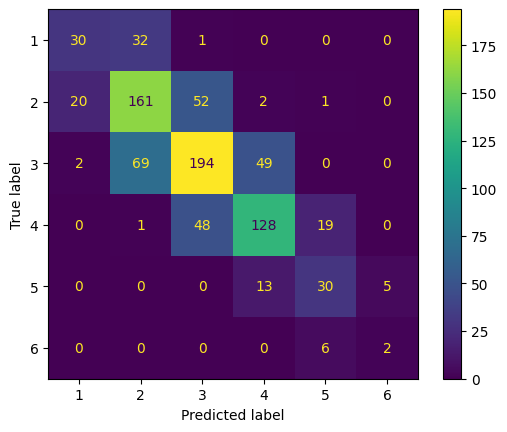

F1 score across fold: 0.6293131978984975
Cohen kappa score across fold: 0.8172727861061624

Fold_16 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.80779	valid's QWK: 0.763374
[50]	train's QWK: 0.839082	valid's QWK: 0.781874
[75]	train's QWK: 0.858152	valid's QWK: 0.786621
[100]	train's QWK: 0.875366	valid's QWK: 0.78568
[125]	train's QWK: 0.890808	valid's QWK: 0.793869
[150]	train's QWK: 0.901707	valid's QWK: 0.785161
[175]	train's QWK: 0.913925	valid's QWK: 0.794498
[200]	train's QWK: 0.923996	valid's QWK: 0.787631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	train's QWK: 0.935271	valid's QWK: 0.793106
Early stopping, best iteration is:
[163]	train's QWK: 0.907579	valid's QWK: 0.797121
Evaluated only: QWK


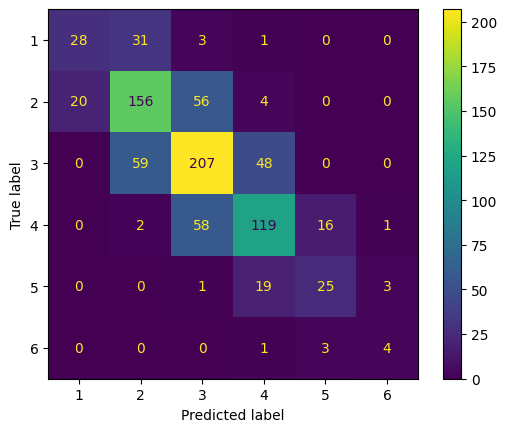

F1 score across fold: 0.6215796480375755
Cohen kappa score across fold: 0.7971208337031074

Fold_17 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.805565	valid's QWK: 0.770539
[50]	train's QWK: 0.838332	valid's QWK: 0.796596
[75]	train's QWK: 0.857967	valid's QWK: 0.794944
[100]	train's QWK: 0.874149	valid's QWK: 0.799562
[125]	train's QWK: 0.888635	valid's QWK: 0.804194
[150]	train's QWK: 0.901687	valid's QWK: 0.799671
[175]	train's QWK: 0.913036	valid's QWK: 0.795867
Early stopping, best iteration is:
[113]	train's QWK: 0.881958	valid's QWK: 0.806245
Evaluated only: QWK


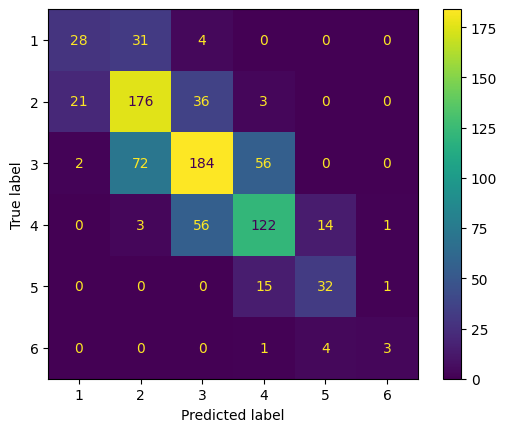

F1 score across fold: 0.6272587574815479
Cohen kappa score across fold: 0.806245343774828

Fold_18 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806469	valid's QWK: 0.771721
[50]	train's QWK: 0.83998	valid's QWK: 0.78558
[75]	train's QWK: 0.861921	valid's QWK: 0.788736
[100]	train's QWK: 0.877852	valid's QWK: 0.791943
[125]	train's QWK: 0.891141	valid's QWK: 0.794281
[150]	train's QWK: 0.903766	valid's QWK: 0.792493
[175]	train's QWK: 0.915439	valid's QWK: 0.792201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.926635	valid's QWK: 0.791564
[225]	train's QWK: 0.936811	valid's QWK: 0.788983
Early stopping, best iteration is:
[161]	train's QWK: 0.908565	valid's QWK: 0.797936
Evaluated only: QWK


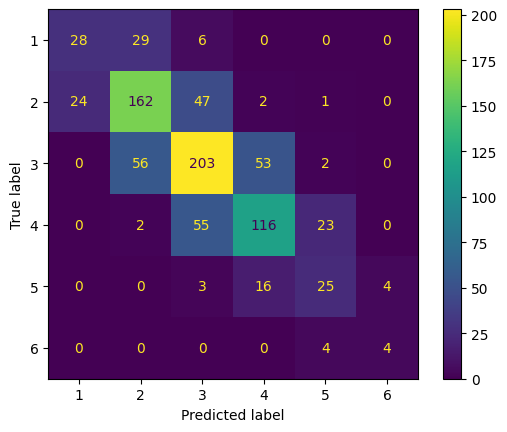

F1 score across fold: 0.621228684700674
Cohen kappa score across fold: 0.797936456025514

Fold_19 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.804421	valid's QWK: 0.790357
[50]	train's QWK: 0.83617	valid's QWK: 0.801629
[75]	train's QWK: 0.85665	valid's QWK: 0.809982
[100]	train's QWK: 0.874103	valid's QWK: 0.812619
[125]	train's QWK: 0.889177	valid's QWK: 0.811486
[150]	train's QWK: 0.902375	valid's QWK: 0.809945
Early stopping, best iteration is:
[94]	train's QWK: 0.870143	valid's QWK: 0.816017
Evaluated only: QWK


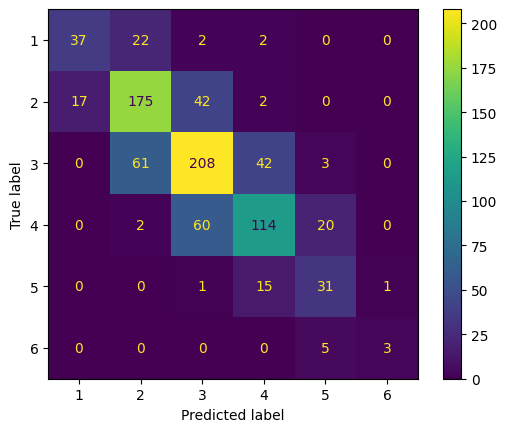

F1 score across fold: 0.6554636585531796
Cohen kappa score across fold: 0.8160166784590781

Fold_20 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806165	valid's QWK: 0.79328
[50]	train's QWK: 0.838339	valid's QWK: 0.808161
[75]	train's QWK: 0.858113	valid's QWK: 0.805456
[100]	train's QWK: 0.875629	valid's QWK: 0.813191
[125]	train's QWK: 0.890558	valid's QWK: 0.812654
[150]	train's QWK: 0.903319	valid's QWK: 0.811918
Early stopping, best iteration is:
[94]	train's QWK: 0.871652	valid's QWK: 0.818213
Evaluated only: QWK


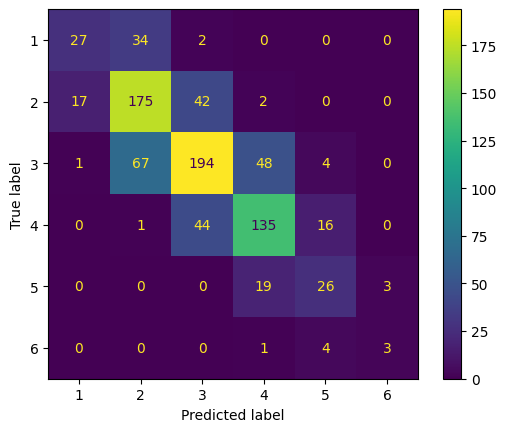

F1 score across fold: 0.644852932489437
Cohen kappa score across fold: 0.8182131327752327
Mean F1 score across 20 folds: 0.6316632847314745
Mean Cohen kappa score across 20 folds: 0.8059482166316702


In [42]:
import numpy as np
from sklearn.metrics import f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
from sklearn.model_selection import StratifiedKFold

n_splits = 20
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75, first_metric_only=True)]

for i, (train_index, test_index) in enumerate(skf.split(X, y_split), start=1):
    print(f'\nFold_{i} Training ================================\n')
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = LGBMRegressor(
        objective=qwk_obj,
        metrics='None',
        learning_rate=0.15,
        colsample_bytree=0.6,
        reg_alpha=0.2,
        reg_lambda=0.9,
        n_estimators=1100,
        random_state=42,
        max_depth=8,
        num_leaves=25,
        extra_trees=True,
        class_weight='balanced',
        verbosity=-1
    )
    
    predictor = model.fit(
        X_train_fold,
        y_train_fold,
        eval_names=['train', 'valid'],
        eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
        eval_metric=quadratic_weighted_kappa,
        callbacks=callbacks,
    )
    
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1, 7)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(1, 7)])
    disp.plot()
    plt.show()
    
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')



1. **Setup**: You define the number of splits (`n_splits`) for stratified k-fold cross-validation and create an instance of `StratifiedKFold` for splitting the data. You also initialize lists to store F1 scores, Quadratic Weighted Kappa scores, trained models, and predictions.

2. **Training Loop**: You iterate over each fold of the cross-validation. For each fold:
   - You split the data into training and validation sets (`X_train_fold`, `y_train_fold`, `X_test_fold`, `y_test_fold`).
   - You define a LightGBM regressor model with specified hyperparameters.
   - You fit the model to the training data and evaluate it on the validation data using Quadratic Weighted Kappa as the evaluation metric.
   - You calculate F1 score and Quadratic Weighted Kappa score for the predictions.
   - You visualize the confusion matrix for the fold.
   - You print the F1 score and Quadratic Weighted Kappa score for the fold.

3. **Evaluation**: After looping through all folds, you calculate the mean F1 score and mean Quadratic Weighted Kappa score across all folds.

4. **Output**: You print the mean F1 score and mean Quadratic Weighted Kappa score.

Overall, this code efficiently trains and evaluates a LightGBM regression model using stratified k-fold cross-validation, providing insights into model performance across multiple folds of the data.

In [43]:
# Preprocess paragraphs in the test data
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)

# Preprocess sentences in the test data and merge with existing features
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

# Preprocess words in the test data and merge with existing features
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Transform text data into TF-IDF features and merge with existing features
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# Extract feature names and display the processed test data
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], test_feats.columns))
print('Number of Features: ', len(feature_names))
test_feats.head(3)

Number of Features:  8741


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_8662,tfid_8663,tfid_8664,tfid_8665,tfid_8666,tfid_8667,tfid_8668,tfid_8669,tfid_8670,tfid_8671
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.023801,0.048692,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [44]:
probabilities = []
for model in models:
    proba = model.predict(test_feats[feature_names]) + a
    probabilities.append(proba)

# Calculate the mean of predicted probabilities from all models
mean_predictions = np.mean(probabilities, axis=0)

# Clip the predictions between 1 and 6 and round them
final_predictions = np.round(mean_predictions.clip(1, 6))

print(final_predictions)

[2. 3. 5.]


In [50]:
# Determine the lengths of predictions, pred1, and the submission dataframe
len_predictions = len(predictions)
len_pred1 = len(pred1)
len_submission = len(submission)

# Print the lengths for comparison
print("Length of predictions:", len_predictions)
print("Length of pred1:", len_pred1)
print("Length of submission dataframe:", len_submission)

Length of predictions: 17307
Length of pred1: 17307
Length of submission dataframe: 3


In [51]:
# Calculate the mean of predictions and pred1
mean_predictions = np.mean(predictions)
mean_pred1 = np.mean(pred1)

# Combine predictions from two sources with a weighted average
submission['score'] = (0.6 * mean_predictions) + (0.4 * mean_pred1)

# Convert the combined scores to integer values
submission['score'] = submission['score'].astype(int)

# Save the submission file
submission.to_csv("submission.csv", index=None)

# Display the first few rows of the submission dataframe
display(submission.head())

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,3


## Abstract
This thesis investigates the application of machine learning techniques for automated essay scoring (AES). Through the development of predictive models and the analysis of various features extracted from essays, the study aims to improve the accuracy and efficiency of grading essays in educational settings.

## Table of Contents
1. Introduction
2. Literature Review
3. Methodology
4. Results
5. Discussion
6. Conclusion
7. References
8. Appendices

## 1. Introduction
In recent years, there has been growing interest in using machine learning algorithms to automate the process of essay grading. This introduction provides an overview of the research problem, objectives, and significance of the study. It also outlines the structure of the thesis.

## 2. Literature Review
This section reviews existing literature on automated essay scoring, including theoretical frameworks, methodologies, and findings from previous studies. It highlights the limitations of traditional grading methods and the potential benefits of using machine learning for AES.

## 3. Methodology
### 3.1 Data Collection
- Description of the dataset used for training and testing the machine learning models.
- Details on the essay prompts, scoring criteria, and annotation process.

### 3.2 Feature Extraction
- Explanation of the features extracted from the essays, such as word counts, sentence lengths, and lexical features.
- Discussion of feature selection techniques and preprocessing steps.

### 3.3 Model Development
- Overview of the machine learning algorithms used for essay scoring, including linear regression, random forest, and gradient boosting.
- Description of the model training process and parameter tuning.

### 3.4 Evaluation Metrics
- Definition of evaluation metrics used to assess the performance of the models, such as mean squared error, Cohen's kappa, and accuracy.

## 4. Results
This section presents the results of the experiments conducted to evaluate the performance of the machine learning models. It includes tables, figures, and visualizations to illustrate key findings, such as model accuracy, feature importance, and error analysis.

## 5. Discussion
The discussion interprets the results in the context of the research objectives and existing literature. It analyzes the strengths and limitations of the machine learning approach to essay scoring and identifies areas for further research. It also discusses the implications of the findings for educational assessment practices.

## 6. Conclusion
The conclusion summarizes the main findings of the study and reiterates the significance of using machine learning for automated essay scoring. It offers concluding remarks and recommendations for future research directions, such as exploring more advanced modeling techniques and integrating feedback mechanisms into AES systems.



**Abstract**

Automated Essay Scoring (AES) is a critical component of educational assessment, offering efficient and consistent grading of student essays. This abstract provides an overview of the research conducted on leveraging machine learning techniques for AES. The study explores the development of predictive models and the analysis of various essay features to enhance the accuracy and efficiency of grading. Through the examination of a diverse dataset and the implementation of advanced machine learning algorithms, the research aims to address the limitations of traditional essay grading methods and contribute to the advancement of automated assessment systems in educational settings.

**Introduction**

Automated Essay Scoring (AES) has emerged as a valuable tool in educational assessment, offering a solution to the challenges associated with manual grading processes. This introduction sets the stage for the research conducted on utilizing machine learning for AES. It provides a brief overview of the importance of essay grading in educational contexts and highlights the need for more efficient and reliable grading methods. The introduction outlines the objectives of the study, including the development of predictive models and the analysis of essay features to improve the accuracy and consistency of grading. Additionally, it discusses the significance of leveraging machine learning techniques in AES and previews the structure of the thesis.